# Step 1: Initiate Pyspark session

In [7]:
from pyspark.sql import SparkSession

def create_spark(app_name="BMW_Sales_Pipeline"):

    # Creating Spark Session
    spark = (
        SparkSession.builder
        # Name of your Spark application
        .appName(app_name)   
        # Run Spark on your local computer using all CPU cores
        .master("local[*]")       
        .getOrCreate()
    )

    spark.sparkContext.setLogLevel("WARN")
    return spark

# Directly running the file
if __name__ == "__main__":
    spark = create_spark()
    print("Spark is ready!")
    print("Spark version is ", spark.version)

Spark is ready!
Spark version is  3.4.1


-----------------------------------------------------------------------------------------------------------------------------------------------------

# Step-2 Loading and Initial Exploration of the Dataset Using PySpark

In [8]:
from pyspark.sql import functions as F
from pyspark.sql import SparkSession

CSV_PATH = r"C:\Users\Admin\Downloads\BMW sales data (2010-2024).csv"

def load_csv(spark, path=CSV_PATH):
    df = spark.read.csv(path, header=True, inferSchema=True, multiLine=True, escape='"')
    return df

def basic_inspect(df, sample_n=10, distinct_preview_n=8):
    print("\n--- Schema ---")
    df.printSchema()

    total = df.count()
    print(f"\n--- Total rows: {total} ---")

    print(f"\n--- Sample {sample_n} rows ---")
    df.show(sample_n, truncate=False)

    # Columns list
    cols = df.columns
    print("\n======= Columns (count: {}) =======".format(len(cols)))
    for c in cols:
        print("-", c)

    # Null counts per column
    exprs = [
        F.sum(F.when((F.col(c).isNull()) | (F.trim(F.col(c)) == ""), 1).otherwise(0)).alias(c)
        for c in cols
    ]
    nulls_row = df.select(exprs).collect()[0].asDict()
    print("\nNull / empty counts per column ")
    for k, v in nulls_row.items():
        print(f"{k}: {v}")

    # Distinct counts
    print(f"\n--- Distinct counts (first {distinct_preview_n} columns) ---")
    for c in cols[:distinct_preview_n]:
        cnt = df.select(F.countDistinct(F.col(c))).collect()[0][0]
        print(f"{c}: {cnt} distinct")

  
    date_candidates = [c for c in cols if any(k in c.lower() for k in ("date", "year", "month", "day"))]
    print("\n======== Potential date-related columns =======", date_candidates)

    # Do a small parse check
    for c in date_candidates:
        dtype = dict(df.dtypes)[c]
        if dtype == "string":
            df1 = df.withColumn("_tmp1", F.to_date(F.col(c), "yyyy-MM-dd"))
            ok1 = df1.filter(F.col("_tmp1").isNotNull()).count()
            df2 = df.withColumn("_tmp2", F.to_date(F.col(c), "dd/MM/yyyy"))
            ok2 = df2.filter(F.col("_tmp2").isNotNull()).count()
            print(f"  Column '{c}' (string): parses as yyyy-MM-dd -> {ok1} rows; dd/MM/yyyy -> {ok2} rows")
        else:
            print(f"  Column '{c}': detected dtype = {dtype}")

if __name__ == "__main__":
    
    spark = SparkSession.builder.master("local[*]").appName("BMW_Sales_Step1b").getOrCreate()
    spark.sparkContext.setLogLevel("WARN")

    print("Loading CSV from ", CSV_PATH)
    df = load_csv(spark, CSV_PATH)
    basic_inspect(df)


Loading CSV from  C:\Users\Admin\Downloads\BMW sales data (2010-2024).csv

--- Schema ---
root
 |-- Model: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Region: string (nullable = true)
 |-- Color: string (nullable = true)
 |-- Fuel_Type: string (nullable = true)
 |-- Transmission: string (nullable = true)
 |-- Engine_Size_L: double (nullable = true)
 |-- Mileage_KM: integer (nullable = true)
 |-- Price_USD: integer (nullable = true)
 |-- Sales_Volume: integer (nullable = true)
 |-- Sales_Classification: string (nullable = true)


--- Total rows: 50000 ---

--- Sample 10 rows ---
+--------+----+-------------+------+---------+------------+-------------+----------+---------+------------+--------------------+
|Model   |Year|Region       |Color |Fuel_Type|Transmission|Engine_Size_L|Mileage_KM|Price_USD|Sales_Volume|Sales_Classification|
+--------+----+-------------+------+---------+------------+-------------+----------+---------+------------+--------------------+
|5 Se

-----------------------------------------------------------------------------------------------------------------------------------------------------

# Step-3 Data Cleaning & Standardisation Pipeline



In [9]:
from pyspark.sql import SparkSession, functions as F, types as T

CSV_PATH = r"C:\Users\Admin\Downloads\BMW sales data (2010-2024).csv"

def create_spark_if_needed(app_name="BMW_Sales_Pipeline_Step2"):
    spark = SparkSession.builder.master("local[*]").appName(app_name).getOrCreate()
    spark.sparkContext.setLogLevel("WARN")
    return spark

def to_snake_case(col_name: str) -> str:
    import re
    s = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', col_name)
    s = re.sub('([a-z0-9])([A-Z])', r'\1_\2', s)
    s = s.replace(" ", "_").replace("-", "_")
    s = re.sub('[^0-9a-zA-Z_]', '', s)
    return s.lower()

def standardize_column_names(df):
    new_names = [to_snake_case(c) for c in df.columns]
    for old, new in zip(df.columns, new_names):
        if old != new:
            df = df.withColumnRenamed(old, new)
    return df

def clean_string_columns(df, string_cols):
    for c in string_cols:
        # trim whitespace and collapse multiple spaces
        df = df.withColumn(c, F.when(F.col(c).isNull(), None).otherwise(F.trim(F.regexp_replace(F.col(c), r'\\s+', ' '))))
    return df

def normalize_categories(df):
    # Title-case common categorical columns for consistency
    for c in ["transmission", "fuel_type", "region", "color", "sales_classification", "model"]:
        if c in df.columns:
            df = df.withColumn(c, F.initcap(F.col(c)))
    # Standardize sales_classification to a small set
    if "sales_classification" in df.columns:
        df = df.withColumn("sales_classification",
                           F.when(F.col("sales_classification").isin("High","Low","Medium"),
                                  F.col("sales_classification")).otherwise(F.lit("Unknown")))
    return df

def enforce_types(df):
    # Cast numeric columns defensively
    if "year" in df.columns:
        df = df.withColumn("year", F.col("year").cast(T.IntegerType()))
    if "engine_size_l" in df.columns:
        df = df.withColumn("engine_size_l", F.col("engine_size_l").cast(T.DoubleType()))
    if "mileage_km" in df.columns:
        df = df.withColumn("mileage_km", F.col("mileage_km").cast(T.LongType()))
    if "price_usd" in df.columns:
        df = df.withColumn("price_usd", F.col("price_usd").cast(T.DoubleType()))
    if "sales_volume" in df.columns:
        df = df.withColumn("sales_volume", F.col("sales_volume").cast(T.IntegerType()))
    return df

def add_time_columns(df):
    if "year" in df.columns:
        df = df.withColumn("sale_year", F.col("year").cast(T.IntegerType()))
        df = df.withColumn("sale_date", F.to_date(F.concat_ws("-", F.col("sale_year"), F.lit("01"), F.lit("01")), "yyyy-MM-dd"))
    return df

def remove_duplicates(df):
    before = df.count()
    df = df.dropDuplicates()
    after = df.count()
    return df, before, after

def flag_outliers_iqr(df, col_name, prefix="flag"):
    # compute approximate quantiles; if col is missing, skip
    if col_name not in df.columns:
        return df
    try:
        q1, q3 = df.approxQuantile(col_name, [0.25, 0.75], 0.01)
    except Exception:
        return df
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    flag_col = f"{prefix}_{col_name}_outlier"
    df = df.withColumn(flag_col, (F.col(col_name) < F.lit(lower)) | (F.col(col_name) > F.lit(upper)))
    return df

def data_quality_summary(df):
    print("\n--- New Schema ---")
    df.printSchema()
    total = df.count()
    print(f"\n--- Total rows after cleaning: {total} ---")
    print("\n--- Sample rows (10) ---")
    df.show(10, truncate=False)
    print("\n--- Distinct counts for key columns ---")
    for c in ["model","region","fuel_type","transmission","sales_classification"]:
        if c in df.columns:
            cnt = df.select(F.countDistinct(F.col(c))).collect()[0][0]
            sample_vals = [r[0] for r in df.select(c).distinct().limit(10).collect()]
            print(f"{c}: {cnt} distinct, sample: {sample_vals}")

if __name__ == "__main__":
    spark = create_spark_if_needed()
    print("Loading CSV from:", CSV_PATH)
    raw = spark.read.csv(CSV_PATH, header=True, inferSchema=True, multiLine=True, escape='"')

    # Standardize column names
    df = standardize_column_names(raw)

    # Clean string columns: trim and collapse whitespace
    string_cols = [c for c, t in df.dtypes if t == "string"]
    df = clean_string_columns(df, string_cols)

    # Normalize categorical values
    df = normalize_categories(df)

    # Enforce numeric types
    df = enforce_types(df)

    # Add time helpers
    df = add_time_columns(df)

    # Remove duplicates
    df, before_dup, after_dup = remove_duplicates(df)
    print(f"\nDropped duplicates: before={before_dup}, after={after_dup}")

    # Flag numeric outliers for mileage_km & price_usd using IQR method
    df = flag_outliers_iqr(df, "mileage_km", prefix="flag")
    df = flag_outliers_iqr(df, "price_usd", prefix="flag")

    # Final Quality summary
    data_quality_summary(df)

Loading CSV from: C:\Users\Admin\Downloads\BMW sales data (2010-2024).csv

Dropped duplicates: before=50000, after=50000

--- New Schema ---
root
 |-- model: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- region: string (nullable = true)
 |-- color: string (nullable = true)
 |-- fuel__type: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- engine__size_l: double (nullable = true)
 |-- mileage_km: long (nullable = true)
 |-- price_usd: double (nullable = true)
 |-- sales__volume: integer (nullable = true)
 |-- sales__classification: string (nullable = true)
 |-- sale_year: integer (nullable = true)
 |-- sale_date: date (nullable = true)
 |-- flag_mileage_km_outlier: boolean (nullable = true)
 |-- flag_price_usd_outlier: boolean (nullable = true)


--- Total rows after cleaning: 50000 ---

--- Sample rows (10) ---
+--------+----+-------------+-----+----------+------------+--------------+----------+---------+-------------+---------------------+-

-----------------------------------------------------------------------------------------------------------------------------------------------------

# Step-4 Advanced Data Cleaning & Validation

In [10]:
from pyspark.sql import SparkSession, functions as F, types as T
import re

CSV_PATH = r"C:\Users\Admin\Downloads\BMW sales data (2010-2024).csv"

# Spark initialization
spark = SparkSession.builder.master("local[*]").appName("BMW_Step2_Advanced").getOrCreate()
spark.sparkContext.setLogLevel("WARN")

# Helpers
def tidy_name(colname):
    col = colname.strip()
    col = col.replace(" ", "_")
    col = re.sub(r'__+', '_', col)            # collapse multiple underscores
    col = re.sub(r'[^0-9A-Za-z_]', '', col)   # remove any non-alphanumeric/underscore
    return col.lower()

def pctile_expr(col, q=0.5):
    # create an expression for percentile_approx calls
    return F.expr(f"percentile_approx({col},{q})")

# Data-driven thresholds (from dataset profiling)
YEAR_MIN, YEAR_MAX = 2010, 2024
PRICE_MIN = 500.0
PRICE_P99_CAP = 119134.0
MILEAGE_MIN = 0.0
MILEAGE_P99_CAP = 198047.0
ENGINE_MIN = 0.8
ENGINE_P99_CAP = 5.0

# Load CSV and tidy column names 
raw = spark.read.csv(CSV_PATH, header=True, inferSchema=True, multiLine=True, escape='"')

for c in raw.columns:
    raw = raw.withColumnRenamed(c, tidy_name(c))

df = raw

# Keep original raw copy for traceability
df = df.withColumnRenamed("price_usd", "price_usd_orig") \
       .withColumnRenamed("mileage_km", "mileage_km_orig") \
       .withColumnRenamed("engine_size_l", "engine_size_l_orig") \
       .withColumnRenamed("sales_volume", "sales_volume_orig") \
       .withColumnRenamed("year", "year_orig")

# Recreate cleaned column names (we'll fill these)
df = df.withColumn("price_usd", F.col("price_usd_orig").cast(T.DoubleType())) \
       .withColumn("mileage_km", F.col("mileage_km_orig").cast(T.LongType())) \
       .withColumn("engine_size_l", F.col("engine_size_l_orig").cast(T.DoubleType())) \
       .withColumn("sales_volume", F.col("sales_volume_orig").cast(T.IntegerType())) \
       .withColumn("year", F.col("year_orig").cast(T.IntegerType()))

# Trim string columns and normalize categories
for name, dtype in df.dtypes:
    if dtype == "string":
        df = df.withColumn(name, F.trim(F.regexp_replace(F.col(name), r'\s+', ' ')))
        if name in ("model","region","color","fuel_type","transmission","sales_classification"):
            df = df.withColumn(name, F.initcap(F.col(name)))

# create sale_date helper
df = df.withColumn("sale_year", F.col("year"))
df = df.withColumn("sale_date", F.to_date(F.concat_ws("-", F.col("sale_year"), F.lit("01"), F.lit("01")), "yyyy-MM-dd"))

# Initial validation flags (logical checks) 
df = df.withColumn("flag_invalid_year", (F.col("year").isNull()) | (F.col("year") < YEAR_MIN) | (F.col("year") > YEAR_MAX))
df = df.withColumn("flag_invalid_price", (F.col("price_usd").isNull()) | (F.col("price_usd") < PRICE_MIN))
df = df.withColumn("flag_invalid_mileage", (F.col("mileage_km").isNull()) | (F.col("mileage_km") < 0))
df = df.withColumn("flag_invalid_engine", (F.col("engine_size_l").isNull()) | (F.col("engine_size_l") < ENGINE_MIN))
df = df.withColumn("flag_missing_model", F.col("model").isNull())
df = df.withColumn("flag_invalid_critical", 
                   F.col("flag_missing_model") | F.col("flag_invalid_year") | F.col("flag_invalid_price") | F.col("sales_volume").isNull())

#Drop rows with invalid critical fields 
rows_before = df.count()
df = df.filter(~F.col("flag_invalid_critical"))
rows_after_drop = df.count()

#Imputation plan- model-level median 
med_price = df.groupBy("model").agg(F.expr("percentile_approx(price_usd, 0.5)").alias("med_price"))
med_mileage = df.groupBy("model").agg(F.expr("percentile_approx(mileage_km, 0.5)").alias("med_mileage"))
med_engine = df.groupBy("model").agg(F.expr("percentile_approx(engine_size_l, 0.5)").alias("med_engine"))

df = df.join(med_price, on="model", how="left") \
       .join(med_mileage, on="model", how="left") \
       .join(med_engine, on="model", how="left")

# compute global medians (fallback)
global_med_price = df.agg(F.expr("percentile_approx(price_usd,0.5) as g_med_price")).first()["g_med_price"]
global_med_mileage = df.agg(F.expr("percentile_approx(mileage_km,0.5) as g_med_mileage")).first()["g_med_mileage"]
global_med_engine = df.agg(F.expr("percentile_approx(engine_size_l,0.5) as g_med_engine")).first()["g_med_engine"]

# mark imputation needed flags (before we impute)
df = df.withColumn("flag_impute_mileage", F.col("mileage_km").isNull()) \
       .withColumn("flag_impute_engine", F.col("engine_size_l").isNull())

# perform imputation
df = df.withColumn("mileage_km", 
                   F.when(F.col("mileage_km").isNull(), F.coalesce(F.col("med_mileage"), F.lit(global_med_mileage))).otherwise(F.col("mileage_km")))
df = df.withColumn("engine_size_l",
                   F.when(F.col("engine_size_l").isNull(), F.coalesce(F.col("med_engine"), F.lit(global_med_engine))).otherwise(F.col("engine_size_l")))

# create flags that indicate we imputed from model-level vs global
df = df.withColumn("flag_imputed_mileage_from_model", F.col("flag_impute_mileage") & F.col("med_mileage").isNotNull()) \
       .withColumn("flag_imputed_mileage_from_global", F.col("flag_impute_mileage") & F.col("med_mileage").isNull()) \
       .withColumn("flag_imputed_engine_from_model", F.col("flag_impute_engine") & F.col("med_engine").isNotNull()) \
       .withColumn("flag_imputed_engine_from_global", F.col("flag_impute_engine") & F.col("med_engine").isNull())

#Outlier detection (IQR) and winsorization candidate columns
def compute_iqr_bounds(df_local, col):
    q = df_local.approxQuantile(col, [0.25,0.75], 0.01)
    if len(q) < 2:
        return None, None
    q1, q3 = q
    iqr = q3 - q1
    return q1 - 1.5*iqr, q3 + 1.5*iqr

price_iqr_lower, price_iqr_upper = compute_iqr_bounds(df, "price_usd")
mile_iqr_lower, mile_iqr_upper = compute_iqr_bounds(df, "mileage_km")
engine_iqr_lower, engine_iqr_upper = compute_iqr_bounds(df, "engine_size_l")

# create outlier flags 
df = df.withColumn("flag_outlier_price_iqr", (F.col("price_usd") < F.lit(price_iqr_lower)) | (F.col("price_usd") > F.lit(price_iqr_upper))) \
       .withColumn("flag_outlier_mileage_iqr", (F.col("mileage_km") < F.lit(mile_iqr_lower)) | (F.col("mileage_km") > F.lit(mile_iqr_upper))) \
       .withColumn("flag_outlier_engine_iqr", (F.col("engine_size_l") < F.lit(engine_iqr_lower)) | (F.col("engine_size_l") > F.lit(engine_iqr_upper)))

df = df.withColumn("price_usd_capped", F.when(F.col("price_usd") > PRICE_P99_CAP, F.lit(PRICE_P99_CAP)).otherwise(F.col("price_usd"))) \
       .withColumn("mileage_km_capped", F.when(F.col("mileage_km") > MILEAGE_P99_CAP, F.lit(MILEAGE_P99_CAP)).otherwise(F.col("mileage_km"))) \
       .withColumn("engine_size_l_capped", F.when(F.col("engine_size_l") > ENGINE_P99_CAP, F.lit(ENGINE_P99_CAP)).otherwise(F.col("engine_size_l")))

#Summary outputs
print("Rows before any cleaning:", raw.count())
print("Rows after dropping critical invalids:", rows_after_drop)
print("Global medians used (price, mileage, engine):", global_med_price, global_med_mileage, global_med_engine)
print("IQR bounds (price):", price_iqr_lower, price_iqr_upper)
print("IQR bounds (mileage):", mile_iqr_lower, mile_iqr_upper)
print("IQR bounds (engine):", engine_iqr_lower, engine_iqr_upper)

# Null counts
flag_counts = df.select([
    F.sum(F.when(F.col("flag_invalid_critical"),1).otherwise(0)).alias("invalid_critical"),
    F.sum(F.when(F.col("flag_invalid_price"),1).otherwise(0)).alias("invalid_price"),
    F.sum(F.when(F.col("flag_invalid_mileage"),1).otherwise(0)).alias("invalid_mileage"),
    F.sum(F.when(F.col("flag_invalid_engine"),1).otherwise(0)).alias("invalid_engine"),
    F.sum(F.when(F.col("flag_imputed_mileage_from_model"),1).otherwise(0)).alias("imputed_mileage_model"),
    F.sum(F.when(F.col("flag_imputed_mileage_from_global"),1).otherwise(0)).alias("imputed_mileage_global"),
    F.sum(F.when(F.col("flag_imputed_engine_from_model"),1).otherwise(0)).alias("imputed_engine_model"),
    F.sum(F.when(F.col("flag_imputed_engine_from_global"),1).otherwise(0)).alias("imputed_engine_global"),
    F.sum(F.when(F.col("flag_outlier_price_iqr"),1).otherwise(0)).alias("outlier_price_iqr"),
    F.sum(F.when(F.col("flag_outlier_mileage_iqr"),1).otherwise(0)).alias("outlier_mileage_iqr"),
    F.sum(F.when(F.col("flag_outlier_engine_iqr"),1).otherwise(0)).alias("outlier_engine_iqr")
]).collect()[0].asDict()

print("\nFlag counts:")
for k,v in flag_counts.items():
    print(f"  {k}: {v}")

print("\n--- New schema after cleaning ---")
df.printSchema()

print("\n--- Sample rows (top 10) ---")
df.select("model","sale_year","region","price_usd","price_usd_capped","mileage_km","mileage_km_capped","engine_size_l","engine_size_l_capped","sales_volume").show(10, truncate=False)

print("\n--- Top 8 models by total sales (for verification) ---")
df.groupBy("model").agg(F.sum("sales_volume").alias("total_sales")).orderBy(F.desc("total_sales")).show(8, truncate=False)

Rows before any cleaning: 50000
Rows after dropping critical invalids: 50000
Global medians used (price, mileage, engine): 75009.0 100382 3.2
IQR bounds (price): -16479.0 165169.0
IQR bounds (mileage): -103748.5 301519.5
IQR bounds (engine): -0.3999999999999999 6.799999999999999

Flag counts:
  invalid_critical: 0
  invalid_price: 0
  invalid_mileage: 0
  invalid_engine: 0
  imputed_mileage_model: 0
  imputed_mileage_global: 0
  imputed_engine_model: 0
  imputed_engine_global: 0
  outlier_price_iqr: 0
  outlier_mileage_iqr: 0
  outlier_engine_iqr: 0

--- New schema after cleaning ---
root
 |-- model: string (nullable = true)
 |-- year_orig: integer (nullable = true)
 |-- region: string (nullable = true)
 |-- color: string (nullable = true)
 |-- fuel_type: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- engine_size_l_orig: double (nullable = true)
 |-- mileage_km_orig: integer (nullable = true)
 |-- price_usd_orig: integer (nullable = true)
 |-- sales_volume_or

-----------------------------------------------------------------------------------------------------------------------------------------------------

# Step-5 Enhanced Data Quality & Robust Validation

In [11]:
from pyspark.sql import functions as F
from pyspark.sql import Window
import pyspark.sql.types as T
from functools import reduce

print("\n=== Enhanced Data Quality & Further Cleaning ===")

# Cross-field consistency rules
df = df.withColumn(
    "flag_engine_invalid_for_electric",
    F.when((F.col("fuel_type") == "Electric") & (F.col("engine_size_l") > 1.0), True).otherwise(False)
)

df = df.withColumn(
    "flag_engine_invalid_for_hybrid",
    F.when((F.col("fuel_type") == "Hybrid") & ((F.col("engine_size_l") < 1.0) | (F.col("engine_size_l") > 3.0)), True).otherwise(False)
)

df = df.withColumn(
    "flag_high_mileage_high_price",
    F.when((F.col("mileage_km") > 150000) & (F.col("price_usd") > 100000), True).otherwise(False)
)

# Business-rule validation
df = df.withColumn("price_per_liter", F.col("price_usd") / F.col("engine_size_l"))

df = df.withColumn(
    "flag_price_per_liter_outlier",
    F.when((F.col("price_per_liter") < 5000) | (F.col("price_per_liter") > 50000), True).otherwise(False)
)

df = df.withColumn(
    "mileage_band",
    F.when(F.col("mileage_km") < 30000, "Low")
     .when(F.col("mileage_km") < 100000, "Medium")
     .otherwise("High")
)

# Z-score outliers
stats = df.select(
    F.mean("price_usd").alias("mean_price"),
    F.stddev("price_usd").alias("std_price"),
    F.mean("mileage_km").alias("mean_mileage"),
    F.stddev("mileage_km").alias("std_mileage")
).first()

mean_price, std_price = stats.mean_price, stats.std_price
mean_mileage, std_mileage = stats.mean_mileage, stats.std_mileage

df = df.withColumn("z_price", (F.col("price_usd") - mean_price) / std_price)
df = df.withColumn("z_mileage", (F.col("mileage_km") - mean_mileage) / std_mileage)

df = df.withColumn("flag_z_price_outlier", F.abs(F.col("z_price")) > 3)
df = df.withColumn("flag_z_mileage_outlier", F.abs(F.col("z_mileage")) > 3)

# Modified Z-score (robust)
median_price = df.approxQuantile("price_usd", [0.5], 0.01)[0]

# compute MAD: median(abs(price - median_price))
mad_price = df.select(F.expr(f"percentile_approx(abs(price_usd - {median_price}), 0.5)")).first()[0]
# guard: if mad_price is 0 or None, set to small value to avoid div-by-zero
if not mad_price or mad_price == 0:
    mad_price = 1.0

df = df.withColumn("mod_z_price", F.lit(0.6745) * (F.col("price_usd") - F.lit(median_price)) / F.lit(mad_price))
df = df.withColumn("flag_mod_z_price_outlier", F.abs(F.col("mod_z_price")) > 3.5)

# Final quality score
quality_flags = [
    "flag_engine_invalid_for_electric",
    "flag_engine_invalid_for_hybrid",
    "flag_high_mileage_high_price",
    "flag_price_per_liter_outlier",
    "flag_z_price_outlier",
    "flag_z_mileage_outlier",
    "flag_mod_z_price_outlier"
]

# Convert each boolean flag to integer (1/0) and sum them robustly
flag_cols_as_int = [F.when(F.col(f), F.lit(1)).otherwise(F.lit(0)).alias(f + "_int") for f in quality_flags]
# add the int columns temporarily (they will be used to compute quality_issues_count)
for col_expr in flag_cols_as_int:
    df = df.withColumn(col_expr._jc.toString().split(" AS ")[1].strip(), col_expr)  # add new int column

# Build list of the new int column names
int_col_names = [f + "_int" for f in quality_flags]

# Sum int columns to create quality_issues_count (use reduce to add Columns)
sum_expr = reduce(lambda a, b: a + b, [F.col(c) for c in int_col_names])
df = df.withColumn("quality_issues_count", sum_expr)
df = df.withColumn("quality_score", 1 - (F.col("quality_issues_count") / F.lit(len(quality_flags))))

agg_exprs = [
    F.sum(F.when(F.col("flag_engine_invalid_for_electric"), 1).otherwise(0)).alias("electric_engine_invalid"),
    F.sum(F.when(F.col("flag_engine_invalid_for_hybrid"), 1).otherwise(0)).alias("hybrid_engine_invalid"),
    F.sum(F.when(F.col("flag_high_mileage_high_price"), 1).otherwise(0)).alias("high_mileage_high_price"),
    F.sum(F.when(F.col("flag_price_per_liter_outlier"), 1).otherwise(0)).alias("price_per_liter_outliers"),
    F.sum(F.when(F.col("flag_z_price_outlier"), 1).otherwise(0)).alias("z_price_outliers"),
    F.sum(F.when(F.col("flag_z_mileage_outlier"), 1).otherwise(0)).alias("z_mileage_outliers"),
    F.sum(F.when(F.col("flag_mod_z_price_outlier"), 1).otherwise(0)).alias("mod_z_price_outliers"),
    F.sum("quality_issues_count").alias("total_quality_issues_count"),
    F.avg("quality_score").alias("avg_quality_score")
]

print("\n--- Quality Issues Summary ---")
df.select(*agg_exprs).show(truncate=False)

print("\n--- Sample 10 Rows after Step 3 ---")
df.select(
    "model","year","fuel_type","mileage_km","price_usd","engine_size_l",
    "mileage_band","price_per_liter","quality_issues_count","quality_score"
).show(10, truncate=False)


=== Enhanced Data Quality & Further Cleaning ===

--- Quality Issues Summary ---
+-----------------------+---------------------+-----------------------+------------------------+----------------+------------------+--------------------+--------------------------+------------------+
|electric_engine_invalid|hybrid_engine_invalid|high_mileage_high_price|price_per_liter_outliers|z_price_outliers|z_mileage_outliers|mod_z_price_outliers|total_quality_issues_count|avg_quality_score |
+-----------------------+---------------------+-----------------------+------------------------+----------------+------------------+--------------------+--------------------------+------------------+
|12471                  |7107                 |2816                   |3166                    |0               |0                 |0                   |25560                     |0.9269714285714525|
+-----------------------+---------------------+-----------------------+------------------------+----------------+-----

-----------------------------------------------------------------------------------------------------------------------------------------------------

# Step-6 Advanced data quality correction especially for Electric and Hybrid cars

In [12]:
from pyspark.sql import functions as F
from functools import reduce

# (assumes df exists in your Spark session from Step2/Step3)

# Add explicit is_electric/is_hybrid flags
df = df.withColumn("is_electric", F.col("fuel_type") == "Electric")
df = df.withColumn("is_hybrid", F.col("fuel_type") == "Hybrid")

# For Electric rows, null out engine_size_l
#    Keep engine_size_l_orig for traceability
df = df.withColumn("engine_size_l_working", F.when(F.col("is_electric"), None).otherwise(F.col("engine_size_l")))

# Relax hybrid engine rule: allow 0.8 - 4.5 L for hybrids
HYBRID_MIN, HYBRID_MAX = 0.8, 4.5

df = df.withColumn(
    "flag_engine_invalid_for_electric",
    F.when((F.col("is_electric")) & (F.col("engine_size_l_working").isNotNull()), True).otherwise(False)
)

df = df.withColumn(
    "flag_engine_invalid_for_hybrid",
    F.when((F.col("is_hybrid")) & ((F.col("engine_size_l_working") < HYBRID_MIN) | (F.col("engine_size_l_working") > HYBRID_MAX)), True).otherwise(False)
)

# Recompute price_per_liter only where engine_size_l_working is valid
df = df.withColumn("price_per_liter", F.when(F.col("engine_size_l_working").isNotNull() & (F.col("engine_size_l_working") > 0),
                                            F.col("price_usd") / F.col("engine_size_l_working")).otherwise(None))

df = df.withColumn(
    "flag_price_per_liter_outlier",
    F.when(F.col("price_per_liter").isNotNull() & ((F.col("price_per_liter") < 5000) | (F.col("price_per_liter") > 50000)), True).otherwise(False)
)

# Keep the previous "high mileage & high price" rule
df = df.withColumn(
    "flag_high_mileage_high_price",
    F.when((F.col("mileage_km") > 150000) & (F.col("price_usd") > 100000), True).otherwise(False)
)

# Recompute Z-scores (price & mileage) using current numeric columns (price_usd and mileage_km)
stats = df.select(F.mean("price_usd").alias("mean_price"), F.stddev("price_usd").alias("std_price"),
                  F.mean("mileage_km").alias("mean_mileage"), F.stddev("mileage_km").alias("std_mileage")).first()
mean_price, std_price = stats.mean_price, stats.std_price
mean_mileage, std_mileage = stats.mean_mileage, stats.std_mileage

df = df.withColumn("z_price", (F.col("price_usd") - F.lit(mean_price)) / F.lit(std_price))
df = df.withColumn("z_mileage", (F.col("mileage_km") - F.lit(mean_mileage)) / F.lit(std_mileage))

df = df.withColumn("flag_z_price_outlier", F.abs(F.col("z_price")) > 3)
df = df.withColumn("flag_z_mileage_outlier", F.abs(F.col("z_mileage")) > 3)

# Modified Z-score for price
median_price = df.approxQuantile("price_usd", [0.5], 0.01)[0]
mad_price = df.select(F.expr(f"percentile_approx(abs(price_usd - {median_price}), 0.5)")).first()[0]
if not mad_price or mad_price == 0:
    mad_price = 1.0
df = df.withColumn("mod_z_price", F.lit(0.6745) * (F.col("price_usd") - F.lit(median_price)) / F.lit(mad_price))
df = df.withColumn("flag_mod_z_price_outlier", F.abs(F.col("mod_z_price")) > 3.5)

# Rebuild quality_flags list
quality_flags = [
    "flag_engine_invalid_for_electric",
    "flag_engine_invalid_for_hybrid",
    "flag_high_mileage_high_price",
    "flag_price_per_liter_outlier",
    "flag_z_price_outlier",
    "flag_z_mileage_outlier",
    "flag_mod_z_price_outlier"
]

# Convert boolean flags to ints and compute quality_issues_count and quality_score
int_cols = []
for f in quality_flags:
    int_name = f + "_int"
    df = df.withColumn(int_name, F.when(F.col(f), 1).otherwise(0))
    int_cols.append(int_name)

from functools import reduce
sum_expr = reduce(lambda a, b: a + b, [F.col(c) for c in int_cols])
df = df.withColumn("quality_issues_count", sum_expr)
df = df.withColumn("quality_score", 1 - (F.col("quality_issues_count") / F.lit(len(quality_flags))))

# Display the updated quality summary
agg_exprs = [
    F.sum(F.when(F.col("flag_engine_invalid_for_electric"), 1).otherwise(0)).alias("electric_engine_invalid"),
    F.sum(F.when(F.col("flag_engine_invalid_for_hybrid"), 1).otherwise(0)).alias("hybrid_engine_invalid"),
    F.sum(F.when(F.col("flag_high_mileage_high_price"), 1).otherwise(0)).alias("high_mileage_high_price"),
    F.sum(F.when(F.col("flag_price_per_liter_outlier"), 1).otherwise(0)).alias("price_per_liter_outliers"),
    F.sum(F.when(F.col("flag_z_price_outlier"), 1).otherwise(0)).alias("z_price_outliers"),
    F.sum(F.when(F.col("flag_z_mileage_outlier"), 1).otherwise(0)).alias("z_mileage_outliers"),
    F.sum(F.when(F.col("flag_mod_z_price_outlier"), 1).otherwise(0)).alias("mod_z_price_outliers"),
    F.sum("quality_issues_count").alias("total_quality_issues_count"),
    F.avg("quality_score").alias("avg_quality_score")
]

print("\n--- Updated Quality Issues Summary (after electric/hybrid adjustments) ---")
df.select(*agg_exprs).show(truncate=False)

print("\n--- Sample 10 Rows after adjustments ---")
df.select("model","year","fuel_type","is_electric","is_hybrid","mileage_km","price_usd","engine_size_l_working",
          "mileage_band","price_per_liter","quality_issues_count","quality_score").show(10, truncate=False)



--- Updated Quality Issues Summary (after electric/hybrid adjustments) ---
+-----------------------+---------------------+-----------------------+------------------------+----------------+------------------+--------------------+--------------------------+------------------+
|electric_engine_invalid|hybrid_engine_invalid|high_mileage_high_price|price_per_liter_outliers|z_price_outliers|z_mileage_outliers|mod_z_price_outliers|total_quality_issues_count|avg_quality_score |
+-----------------------+---------------------+-----------------------+------------------------+----------------+------------------+--------------------+--------------------------+------------------+
|0                      |1637                 |2816                   |2354                    |0               |0                 |0                   |6807                      |0.9805514285714491|
+-----------------------+---------------------+-----------------------+------------------------+----------------+-----------

-----------------------------------------------------------------------------------------------------------------------------------------------------

# Step-7 Feature Engineering & Aggregations

In [13]:
from pyspark.sql import functions as F
from pyspark.sql import Window

print("\n=== Feature Engineering & Aggregations ===")

w_yoy = Window.partitionBy("model").orderBy("year")

df = df.withColumn(
    "prev_year_sales",
    F.lag("sales_volume", 1).over(w_yoy)
)

df = df.withColumn(
    "yoy_sales_growth",
    F.when(F.col("prev_year_sales").isNull(), None)
     .otherwise((F.col("sales_volume") - F.col("prev_year_sales")) / F.col("prev_year_sales"))
)

df = df.withColumn(
    "avg_model_price_year",
    F.avg("price_usd").over(Window.partitionBy("model", "year"))
)


sales_stats = df.agg(
    F.mean("sales_volume").alias("mean_sales"),
    F.stddev("sales_volume").alias("std_sales")
).first()

mean_sales = sales_stats.mean_sales
std_sales = sales_stats.std_sales

df = df.withColumn(
    "demand_index",
    (F.col("sales_volume") - mean_sales) / std_sales
)


df = df.withColumn(
    "engine_efficiency_score",
    F.when(
        (F.col("price_per_liter").isNotNull()) & (F.col("mileage_km") > 0),
        F.col("price_per_liter") / F.col("mileage_km")
    ).otherwise(None)
)

price_deciles = df.approxQuantile("price_usd", [i/10 for i in range(11)], 0.01)

df = df.withColumn(
    "price_decile",
    F.when(F.col("price_usd") <= price_deciles[1], "D1")
     .when(F.col("price_usd") <= price_deciles[2], "D2")
     .when(F.col("price_usd") <= price_deciles[3], "D3")
     .when(F.col("price_usd") <= price_deciles[4], "D4")
     .when(F.col("price_usd") <= price_deciles[5], "D5")
     .when(F.col("price_usd") <= price_deciles[6], "D6")
     .when(F.col("price_usd") <= price_deciles[7], "D7")
     .when(F.col("price_usd") <= price_deciles[8], "D8")
     .when(F.col("price_usd") <= price_deciles[9], "D9")
     .otherwise("D10")
)

region_total_sales = df.groupBy("region").agg(F.sum("sales_volume").alias("region_sales_total"))

df = df.join(region_total_sales, on="region", how="left")

df = df.withColumn(
    "region_sales_share",
    F.col("sales_volume") / F.col("region_sales_total")
)

w_global_rank = Window.partitionBy().orderBy(F.sum("sales_volume").over(Window.partitionBy("model")).desc())

df = df.withColumn(
    "global_model_rank",
    F.dense_rank().over(Window.orderBy(F.sum("sales_volume").over(Window.partitionBy("model")).desc()))
)

w_reg_rank = Window.partitionBy("region").orderBy(F.sum("sales_volume").over(Window.partitionBy("region", "model")).desc())

df = df.withColumn(
    "regional_model_rank",
    F.dense_rank().over(
        Window.partitionBy("region")
              .orderBy(F.sum("sales_volume").over(Window.partitionBy("region", "model")).desc())
    )
)


# MODEL × YEAR SALES MATRIX
model_year_matrix = df.groupBy("model", "year") \
    .agg(F.sum("sales_volume").alias("total_sales")) \
    .orderBy("model", "year")

# MODEL × REGION SUMMARY
model_region_sales = df.groupBy("model", "region") \
    .agg(
        F.sum("sales_volume").alias("region_sales"),
        F.avg("price_usd").alias("avg_price_region"),
        F.avg("mileage_km").alias("avg_mileage_region")
    ).orderBy("model", "region")

# FUEL TYPE DISTRIBUTION
fuel_distribution = df.groupBy("fuel_type") \
    .agg(
        F.count("*").alias("count"),
        F.sum("sales_volume").alias("total_sales"),
        F.avg("price_usd").alias("avg_price")
    )

# PRICE & MILEAGE SUMMARY PER MODEL
model_stats = df.groupBy("model") \
    .agg(
        F.avg("price_usd").alias("avg_price"),
        F.avg("mileage_km").alias("avg_mileage"),
        F.avg("engine_size_l").alias("avg_engine_size"),
        F.avg("sales_volume").alias("avg_sales"),
        F.sum("sales_volume").alias("total_sales")
    ).orderBy("model")

df_features = df.select(
    "model","year","region","fuel_type","mileage_km","price_usd","engine_size_l_working",
    "sales_volume","demand_index","yoy_sales_growth","mileage_band","price_decile",
    "engine_efficiency_score","region_sales_share","global_model_rank","regional_model_rank",
    "quality_score"
)

print("\n=== Sample of df_features (Top 10) ===")
df_features.show(10, truncate=False)

print("\n=== Model-Year Sales Matrix (Top 10) ===")
model_year_matrix.show(10, truncate=False)

print("\n=== Model-Region Sales Summary (Top 10) ===")
model_region_sales.show(10, truncate=False)


=== Feature Engineering & Aggregations ===

=== Sample of df_features (Top 10) ===
+--------+----+------+---------+----------+---------+---------------------+------------+-------------------+-------------------+------------+------------+-----------------------+---------------------+-----------------+-------------------+------------------+
|model   |year|region|fuel_type|mileage_km|price_usd|engine_size_l_working|sales_volume|demand_index       |yoy_sales_growth   |mileage_band|price_decile|engine_efficiency_score|region_sales_share   |global_model_rank|regional_model_rank|quality_score     |
+--------+----+------+---------+----------+---------+---------------------+------------+-------------------+-------------------+------------+------------+-----------------------+---------------------+-----------------+-------------------+------------------+
|5 Series|2010|Africa|Electric |127690    |74267.0  |null                 |2849        |-0.7765822633588627|-0.6624407582938389|High        |D

-----------------------------------------------------------------------------------------------------------------------------------------------------

# Step-8 Analytical transformations (cohorts, rolling, anomalies, elasticity)

In [14]:
from pyspark.sql import functions as F
from pyspark.sql import Window

df5 = df_features

# Cohort analysis
w_model = Window.partitionBy("model")
df5 = df5.withColumn("model_launch_year", F.min("year").over(w_model)) \
         .withColumn("cohort_age", F.col("year") - F.col("model_launch_year"))

cohort_agg = (
    df5.groupBy("model", "model_launch_year", "cohort_age")
        .agg(F.sum("sales_volume").alias("sum_sales"))
)

# Rolling 3-year sales
model_year = df5.groupBy("model", "year") \
                .agg(F.sum("sales_volume").alias("year_sales"))

w_roll = Window.partitionBy("model").orderBy("year").rowsBetween(-2, 0)
rolling_sales = model_year.withColumn("roll3_sales", F.avg("year_sales").over(w_roll))

# Seasonality or YOY fallback
if "sale_date" in df5.columns:
    season_df = df5.withColumn("sale_date", F.to_date("sale_date")) \
                   .withColumn("month", F.month("sale_date")) \
                   .withColumn("quarter", F.quarter("sale_date"))
    monthly = season_df.groupBy("model", "month").agg(F.sum("sales_volume"))
    quarterly = season_df.groupBy("model", "quarter").agg(F.sum("sales_volume"))
else:
    w_yoy = Window.partitionBy("model").orderBy("year")
    model_year = model_year.withColumn("prev_year_sales", F.lag("year_sales").over(w_yoy)) \
                           .withColumn("yoy_growth_pct",
                                      (F.col("year_sales")-F.col("prev_year_sales"))/
                                      F.col("prev_year_sales"))

# Price anomaly detection
w_price = Window.partitionBy("model")
price_df = (
    df5.withColumn("p_mean", F.avg("price_usd").over(w_price))
       .withColumn("p_std", F.stddev_pop("price_usd").over(w_price))
       .withColumn("p_z", (F.col("price_usd") - F.col("p_mean")) / F.col("p_std"))
       .withColumn("price_anomaly", F.when(F.abs(F.col("p_z")) > 3, 1).otherwise(0))
)
anomaly_summary = price_df.groupBy().agg(F.sum("price_anomaly").alias("anomalies"),
                                         F.count("*").alias("total_rows"))

# Price Elasticity (log-log)
df_el = df5.filter((F.col("sales_volume") > 0) & (F.col("price_usd") > 0)) \
           .withColumn("log_s", F.log("sales_volume")) \
           .withColumn("log_p", F.log("price_usd"))

elasticity = (
    df_el.groupBy("model")
         .agg(F.covar_pop("log_s", "log_p").alias("cov"),
              F.variance("log_p").alias("var_p"))
         .withColumn("elasticity", F.col("cov") / F.col("var_p"))
)

# Dashboard
dashboard = (
    rolling_sales.join(
        df5.groupBy("model")
           .agg(F.min("model_launch_year").alias("launch_year")),
        "model", "left"
    )
    .join(elasticity.select("model", "elasticity"), "model", "left")
)
print("Cohort Analysis:")
cohort_agg.show(5, False)

print("Rolling 3-year sales")
rolling_sales.orderBy("model","year").show(5, False)

print("Anomaly detection:")
anomaly_summary.show()

print("Price Elasticity:")
elasticity.show(5, False)

print("Dashboard:")
dashboard.orderBy("model","year").show(10, False)

Cohort Analysis:
+--------+-----------------+----------+---------+
|model   |model_launch_year|cohort_age|sum_sales|
+--------+-----------------+----------+---------+
|3 Series|2010             |2         |1378152  |
|3 Series|2010             |8         |1620038  |
|3 Series|2010             |11        |1579384  |
|3 Series|2010             |13        |1510756  |
|3 Series|2010             |9         |1459935  |
+--------+-----------------+----------+---------+
only showing top 5 rows

Rolling 3-year sales
+--------+----+----------+------------------+
|model   |year|year_sales|roll3_sales       |
+--------+----+----------+------------------+
|3 Series|2010|1647769   |1647769.0         |
|3 Series|2011|1473102   |1560435.5         |
|3 Series|2012|1378152   |1499674.3333333333|
|3 Series|2013|1448530   |1433261.3333333333|
|3 Series|2014|1682545   |1503075.6666666667|
+--------+----+----------+------------------+
only showing top 5 rows

Anomaly detection:
+---------+----------+
|anoma

-----------------------------------------------------------------------------------------------------------------------------------------------------

# Visualization of Total Global Sales by Top 10 models

Total Sales of all BMW models: 253,375,734
7 Series: 23,786,466
I8: 23,423,891
X1: 23,406,060
3 Series: 23,281,303
I3: 23,133,849
5 Series: 23,097,519
M5: 22,779,688
X3: 22,745,529
X5: 22,709,749
X6: 22,661,986


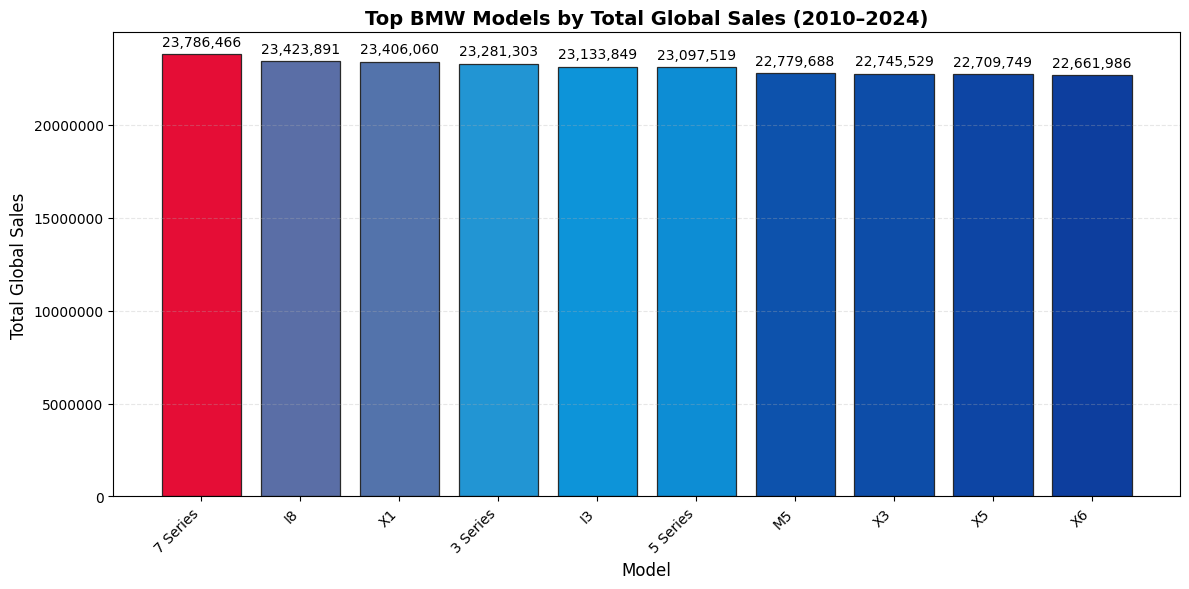

In [15]:
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
import matplotlib as mpl

TOP_N = 10

top_models_df = (
    df5.groupBy("model")
       .agg(F.sum("sales_volume").alias("total_sales"))
       .orderBy(F.desc("total_sales"))
       .limit(TOP_N)
)

rows = top_models_df.collect()  
models = [r["model"] for r in rows]
totals = [int(r["total_sales"]) for r in rows]   # convert to int for formatting

total_all = df5.agg(F.sum("sales_volume").alias("total_all")).collect()[0]["total_all"]
print("Total Sales of all BMW models:", f"{int(total_all):,}")
for m, t in zip(models, totals):
    print(f"{m}: {t:,}")

plt.figure(figsize=(12,6))

bmw_colors = ["#003399", "#009fe3", "#e4002b"]


cmap = mpl.colors.LinearSegmentedColormap.from_list("bmw_metal", bmw_colors, N=256)
norm = mpl.colors.Normalize(vmin=min(totals), vmax=max(totals))
colors = [cmap(norm(v)) for v in totals]

bars = plt.bar(models, totals, color=colors, edgecolor="#222222", linewidth=0.9, alpha=0.95)

labels = [f"{v:,}" for v in totals]    
plt.bar_label(bars, labels=labels, padding=4, fontsize=10)

plt.title("Top BMW Models by Total Global Sales (2010–2024)", fontsize=14, weight="bold")
plt.xlabel("Model", fontsize=12)
plt.ylabel("Total Global Sales", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.gca().ticklabel_format(axis="y", style="plain") 
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------

# Visualization of Year-over-Year Sales Performance of BMW Models

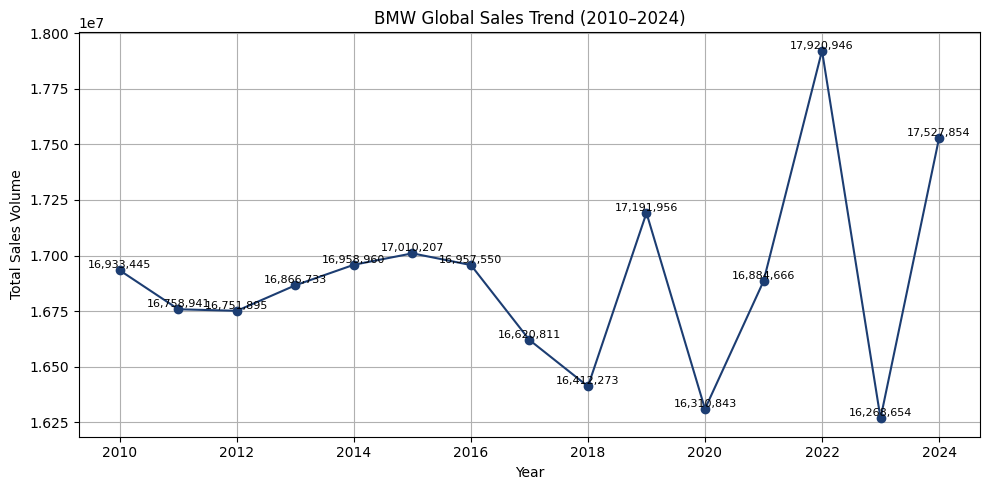

In [16]:
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

yearly = df_features.groupBy("year").agg(F.sum("sales_volume").alias("total_sales")).orderBy("year")
rows = yearly.collect()
years = [r['year'] for r in rows]
totals = [r['total_sales'] for r in rows]

plt.figure(figsize=(10,5))

plt.plot(years, totals, marker='o', color="#1C3D72")

plt.title("BMW Global Sales Trend (2010–2024)")
plt.xlabel("Year")
plt.ylabel("Total Sales Volume")
plt.grid(True)

for x, y in zip(years, totals):
    plt.text(x, y, f"{y:,}", ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------

# Visualization of Price Distribution by Fuel Type


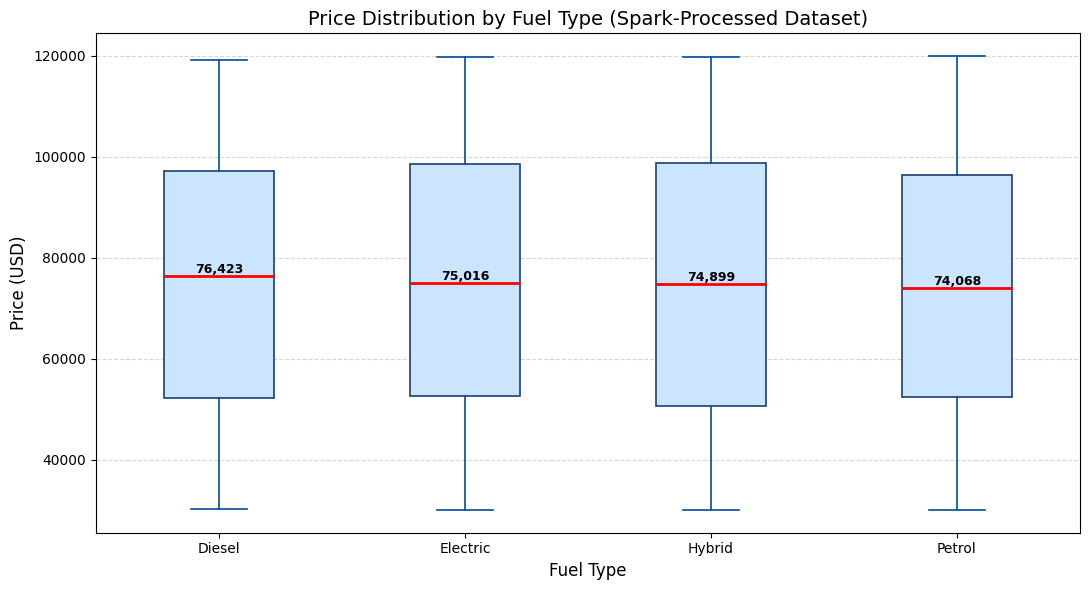

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql import functions as F

# Select limited columns from cleaned Spark DF
sample_df = df5.select("fuel_type", "price_usd").sample(False, 0.05, seed=42)

# Collect into Python list of rows
rows = sample_df.collect()

# Prepare data structures
fuel_types = sorted({row["fuel_type"] for row in rows})

data = []
for f in fuel_types:
    values = [row["price_usd"] for row in rows if row["fuel_type"] == f and row["price_usd"] is not None]
    data.append(values)

# Compute medians for labels
medians = [np.median(vals) if len(vals) > 0 else None for vals in data]

plt.figure(figsize=(11,6))

box = plt.boxplot(
    data,
    tick_labels=fuel_types,
    patch_artist=True,
    showfliers=True,
    boxprops=dict(facecolor="#cce5ff", color="#1C3D72", linewidth=1.2),
    medianprops=dict(color="red", linewidth=2),
    whiskerprops=dict(color="#004c99", linewidth=1.2),
    capprops=dict(color="#004c99", linewidth=1.2),
    flierprops=dict(marker='o', markersize=4, markerfacecolor='#ff6666', alpha=0.6)
)

# Add median labels
for i, m in enumerate(medians):
    if m is not None:
        plt.text(
            i + 1,
            m,
            f"{int(m):,}",
            ha="center",
            va="bottom",
            fontsize=9,
            fontweight="bold"
        )

plt.title("Price Distribution by Fuel Type (Spark-Processed Dataset)", fontsize=14)
plt.xlabel("Fuel Type", fontsize=12)
plt.ylabel("Price (USD)", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()